In [1]:
import jax
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')  # Ensure TF does not see GPU and grab all GPU memory.
tf.random.set_seed(42)  # For reproducibility.

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_quark_gluon_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-08-27 07:21:02.950648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-08-27 07:21:02.950691: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-08-27 07:21:02.950718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-27 07:21:04.969859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Please first ``pip install -U cirq`` to enable related functionality in translation module


In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-SXM4-40GB


(125, 125, 3)


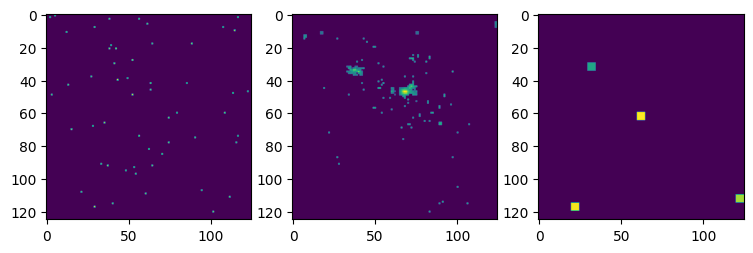

In [3]:
qg_train_dataloader, qg_val_dataloader, qg_test_dataloader = get_quark_gluon_dataloaders(batch_size=256, data_dir=data_dir)
first_image = next(iter(qg_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

In [4]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=64, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=32)
train_and_evaluate(model, qg_train_dataloader, qg_val_dataloader, qg_test_dataloader, num_classes=2, num_epochs=50)

Epoch  50/50: 100%|██████████| 489/489 [00:13<00:00, 35.48batch/s, Loss = 0.5655, AUC = 78.47%]


Total training time = 685.22s, best validation AUC = 78.66% at epoch 47


Testing: 100%|██████████| 39/39 [00:02<00:00, 16.96batch/s, Loss = 0.5599, AUC = 79.67%]


In [5]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=8, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=4)
train_and_evaluate(model, qg_train_dataloader, qg_val_dataloader, qg_test_dataloader, num_classes=2, num_epochs=50)

Epoch  50/50: 100%|██████████| 489/489 [00:12<00:00, 38.93batch/s, Loss = 0.5780, AUC = 76.97%]


Total training time = 684.82s, best validation AUC = 76.97% at epoch 50


Testing: 100%|██████████| 39/39 [00:01<00:00, 23.79batch/s, Loss = 0.5791, AUC = 76.90%]
